### $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [97]:
import numpy as np


def get_epsilon_greedy_action(q_values, epsilon, action_n):
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    return np.random.choice(np.arange(action_n), p=policy)

### Monte-Carlo Algorithm

Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k \in \overline{1,K}$ делаем:

1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).
$$

2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$
Уменьшаем $\varepsilon$


In [98]:
def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99):
    total_rewards = []
    total_interactions = 0  # Total interactions across all episodes
    interactions_history = []  # Store interactions after each episode

    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    counter = np.zeros((state_n, action_n))

    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n
        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state = env.reset()

        for _ in range(trajectory_len):
            trajectory['states'].append(state)

            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            trajectory['actions'].append(action)

            state, reward, done, _ = env.step(action)
            trajectory['rewards'].append(reward)
            total_interactions += 1

            if done:
                break

        total_rewards.append(sum(trajectory['rewards']))

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1

        interactions_history.append(total_interactions)

    return total_rewards, interactions_history

### Solving Taxi-v2 by means of MonteCarlo

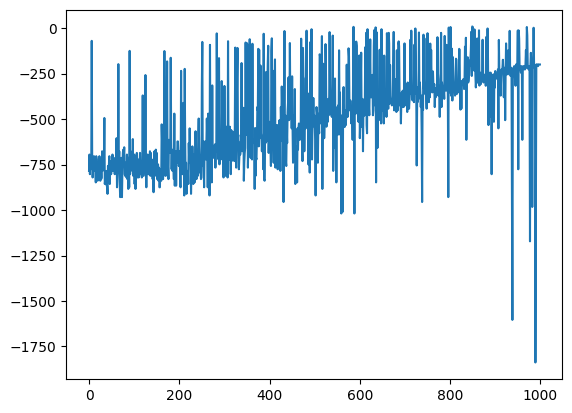

In [99]:
import gym
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3")

total_rewards_MC, interactions_MC = MonteCarlo(env, episode_n=1000, trajectory_len=1000, gamma=0.99)

plt.plot(total_rewards_MC)
plt.show()

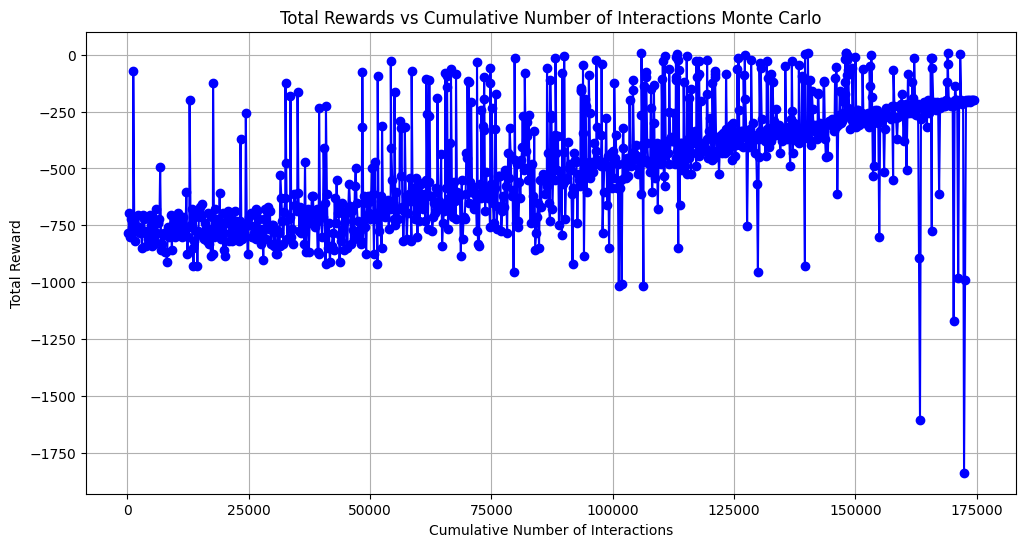

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(interactions_MC, total_rewards_MC, marker='o', color='blue')
plt.title("Total Rewards vs Cumulative Number of Interactions Monte Carlo")
plt.xlabel("Cumulative Number of Interactions")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

### SARSA Algorithm
Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$,
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$, переходим в состояние $S_{t+1}$, совершаем действие $A_{t+1} \sim \pi(\cdot|S_{t+1})$

2. По $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$


In [101]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    total_interactions = 0
    interactions_history = []

    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))

    for episode in range(episode_n):
        epsilon = 1 / (episode + 1)
        state = env.reset()

        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)

            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])

            state = next_state
            action = next_action

            total_rewards[episode] += reward
            total_interactions += 1

            if done:
                break

        interactions_history.append(total_interactions)

    return total_rewards, interactions_history

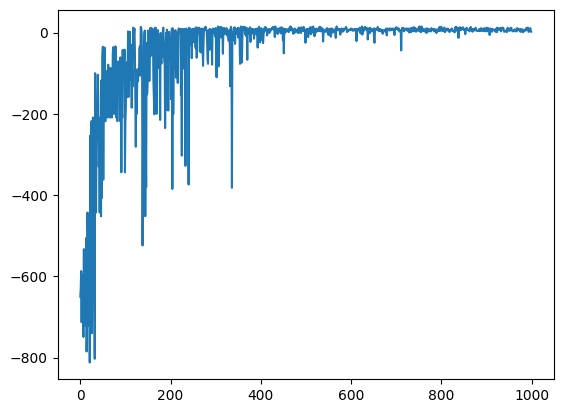

In [102]:
total_rewards_SARSA, interactions_SARSA = SARSA(env, episode_n=1000, trajectory_len=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards_SARSA)
plt.show()

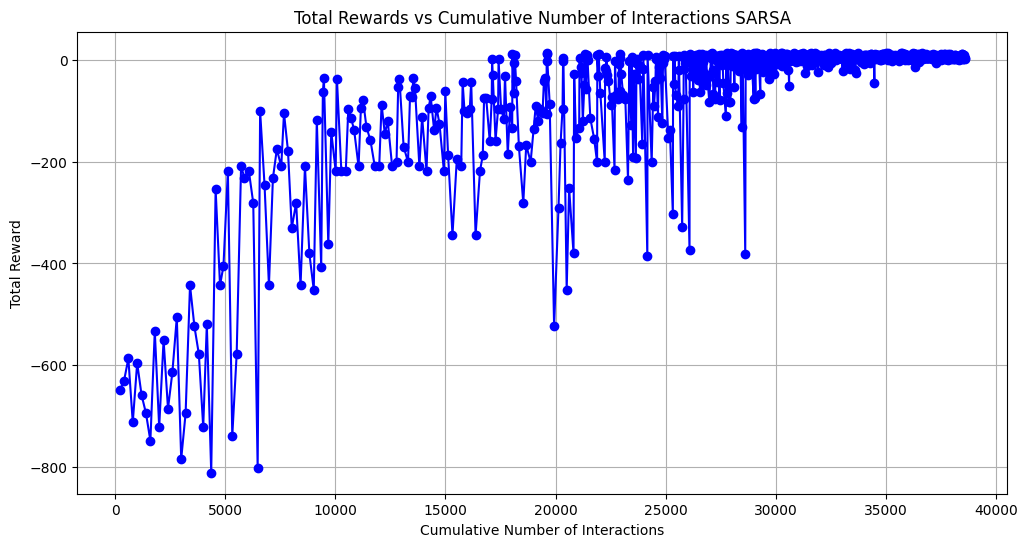

In [120]:
plt.figure(figsize=(12, 6))
plt.plot(interactions_SARSA, total_rewards_SARSA, marker='o', color='blue')
plt.title("Total Rewards vs Cumulative Number of Interactions SARSA")
plt.xlabel("Cumulative Number of Interactions")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [104]:
class TaxiAgentCEM:
    def __init__(self, environment, num_episodes, batch_size, percentile=0.7):
        self.env = environment
        self.num_states = environment.observation_space.n
        self.num_actions = environment.action_space.n
        self.policy_matrix = np.full((self.num_states, self.num_actions), 1 / self.num_actions)
        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.percentile = percentile
        self.environment_interactions = 0

    def select_action(self, current_state):
        action_probabilities = self.policy_matrix[current_state]
        chosen_action = np.random.choice(range(self.num_actions), p=action_probabilities)
        return chosen_action

    def record_trajectory(self, trajectory_length):
        episode_data = {'states': [], 'actions': [], 'total_reward': 0}

        state = self.env.reset()
        self.environment_interactions += 1

        for _ in range(trajectory_length):
            action = self.select_action(state)
            next_state, reward, is_done, _ = self.env.step(action)
            self.environment_interactions += 1

            episode_data['states'].append(state)
            episode_data['actions'].append(action)
            episode_data['total_reward'] += reward

            state = next_state
            if is_done:
                break

        return episode_data

    def update_policy(self, top_trajectories):
        policy_update = np.zeros_like(self.policy_matrix)

        for traj in top_trajectories:
            for state, action in zip(traj['states'], traj['actions']):
                policy_update[state, action] += 1

        for state_idx in range(self.num_states):
            if policy_update[state_idx].sum() > 0:
                self.policy_matrix[state_idx] = policy_update[state_idx] / policy_update[state_idx].sum()
            else:
                continue

    def train(self, max_trajectory_length=100):
        episode_rewards = []
        interaction_history = []

        for episode in range(self.num_episodes):
            batch_trajectories = [self.record_trajectory(max_trajectory_length) for _ in range(self.batch_size)]
            batch_rewards = [traj['total_reward'] for traj in batch_trajectories]
            episode_rewards.append(np.mean(batch_rewards))

            interaction_history.append(self.environment_interactions)

            reward_threshold = np.percentile(batch_rewards, self.percentile * 100)
            elite_trajectories = [traj for traj in batch_trajectories if traj['total_reward'] >= reward_threshold]

            self.update_policy(elite_trajectories)

        return episode_rewards, interaction_history

env = gym.make('Taxi-v3')
cem = TaxiAgentCEM(env, num_episodes=1000, batch_size=20,percentile=0.7)
total_rewards_CEM, interactions_CEM  = cem.train(max_trajectory_length=200)


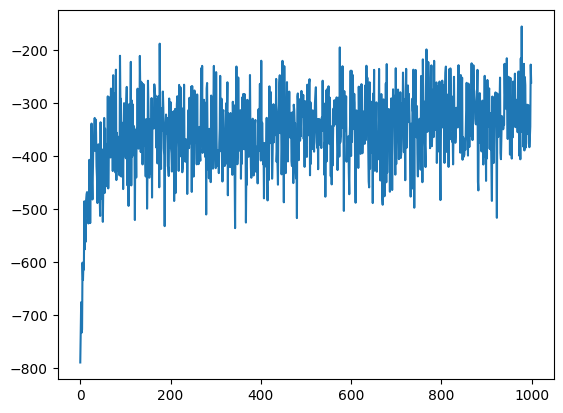

In [105]:
plt.plot(total_rewards_CEM)
plt.show()

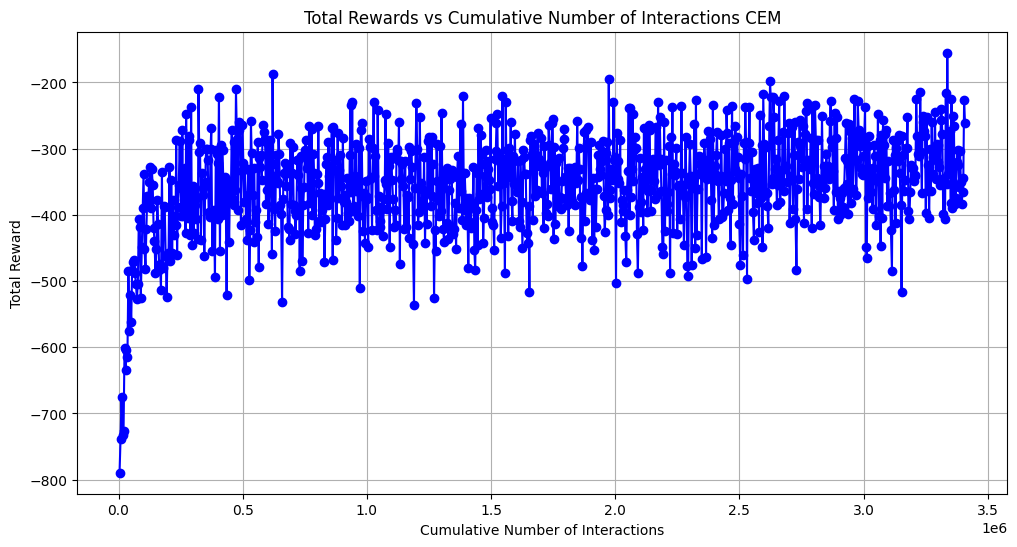

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(interactions_CEM, total_rewards_CEM, marker='o', color='blue')
plt.title("Total Rewards vs Cumulative Number of Interactions CEM")
plt.xlabel("Cumulative Number of Interactions")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

### Q-Learning Algorithm

Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$,
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

2. По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q(S_{t+1},a') - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [107]:
def QLearning(env, episode_n, noisy_episode_n, gamma=0.99, t_max=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    interactions = np.zeros(episode_n)
    cumulative_interactions = 0

    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))

    for episode in range(episode_n):
        if episode < noisy_episode_n:
            epsilon = 1.0
        else:
            epsilon = max(0.01, 1.0 - (episode - noisy_episode_n) / (episode_n - noisy_episode_n))

        state = env.reset()
        cumulative_interactions += 1

        for step in range(t_max):
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            next_state, reward, done, _ = env.step(action)
            cumulative_interactions += 1

            best_next_action = np.argmax(qfunction[next_state])
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][best_next_action] - qfunction[state][action])

            state = next_state
            total_rewards[episode] += reward

            if done:
                break

        interactions[episode] = cumulative_interactions

    return total_rewards, interactions

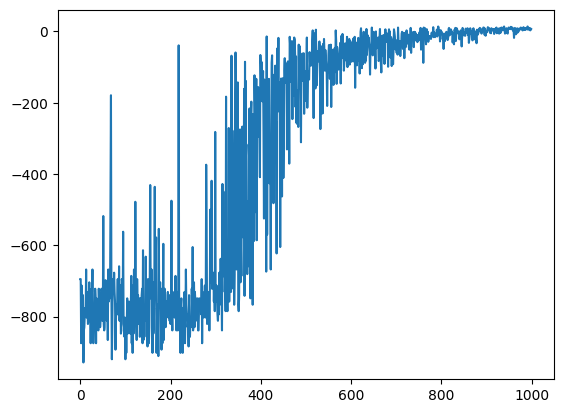

In [108]:
total_rewards_Q, interactions_Q = QLearning(env, episode_n=1000, noisy_episode_n=250, t_max=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards_Q)
plt.show()

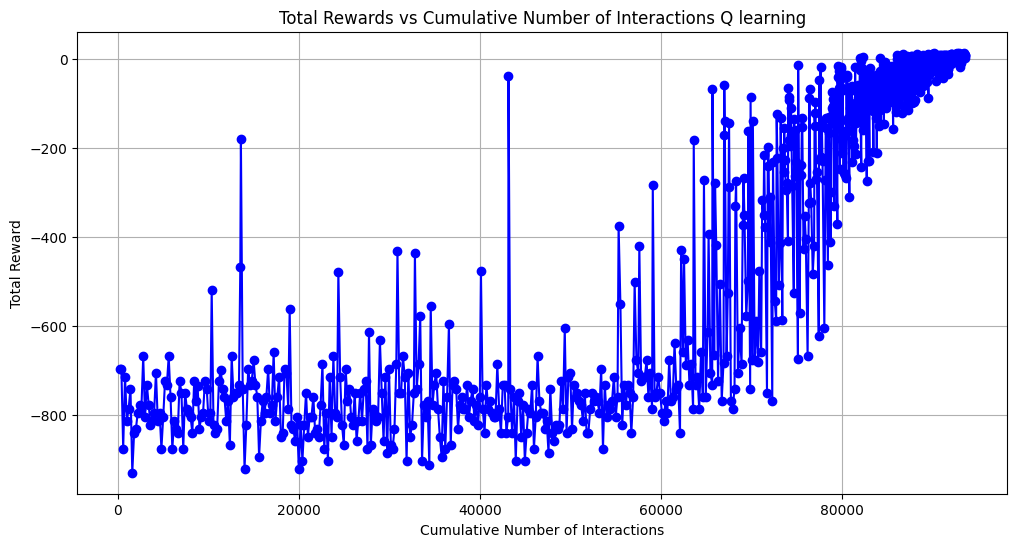

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(interactions_Q, total_rewards_Q, marker='o', color='blue')
plt.title("Total Rewards vs Cumulative Number of Interactions Q learning")
plt.xlabel("Cumulative Number of Interactions")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

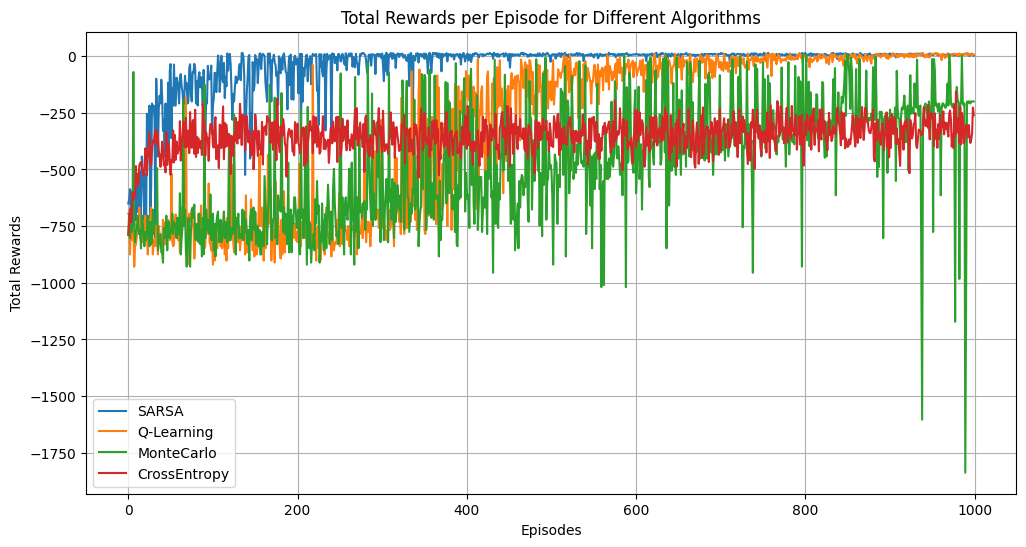

In [110]:
plt.figure(figsize=(12, 6))

plt.plot(total_rewards_SARSA, label='SARSA')
plt.plot(total_rewards_Q, label='Q-Learning')
plt.plot(total_rewards_MC,label='MonteCarlo')
plt.plot(total_rewards_CEM,label='CrossEntropy')

plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Total Rewards per Episode for Different Algorithms')
plt.legend()
plt.grid(True)
plt.show()

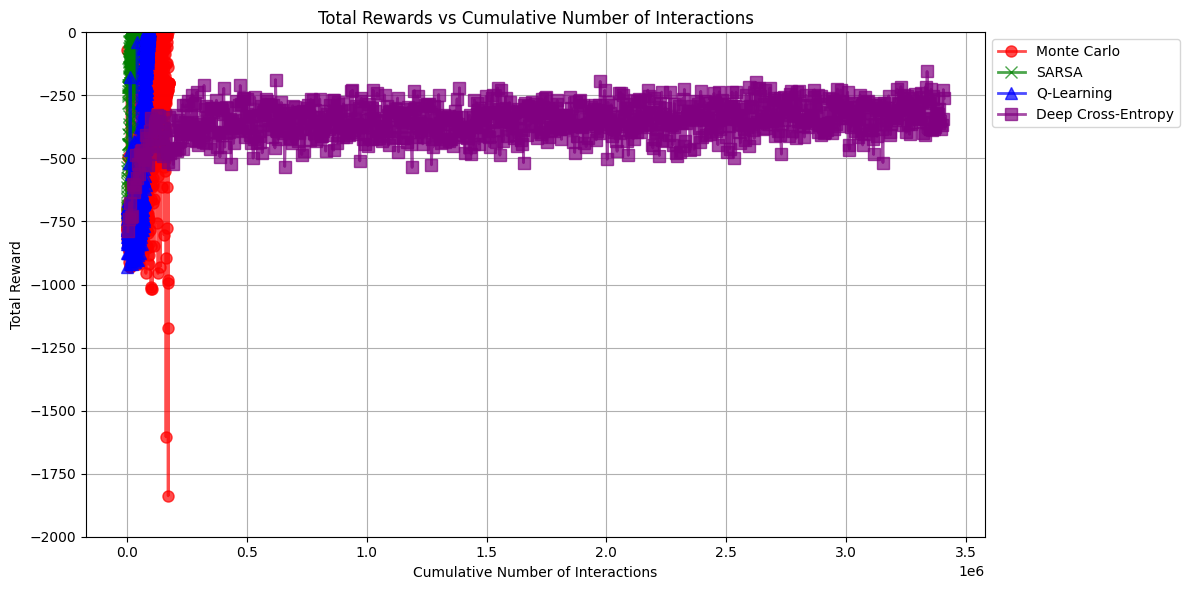

In [114]:
plt.figure(figsize=(12, 6))

plt.plot(interactions_MC, total_rewards_MC, 'o-', color='red', label='Monte Carlo', markersize=8, alpha=0.7, linewidth=2)
plt.plot(interactions_SARSA, total_rewards_SARSA, 'x-', color='green', label='SARSA', markersize=8, alpha=0.7, linewidth=2)
plt.plot(interactions_Q, total_rewards_Q, '^-', color='blue', label='Q-Learning', markersize=8, alpha=0.7, linewidth=2)
plt.plot(interactions_CEM, total_rewards_CEM, 's-', color='purple', label='Deep Cross-Entropy', markersize=8, alpha=0.7, linewidth=2)

plt.ylim(-2000, 0)

plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Cumulative Number of Interactions')
plt.ylabel('Total Reward')
plt.title('Total Rewards vs Cumulative Number of Interactions')

plt.tight_layout()
plt.show()